In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from ordered_set import OrderedSet
import copy 
from statistics import mean
from sklearn.preprocessing import normalize
import pickle
from scipy.stats import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from tqdm import tqdm
from statistics import stdev
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
import pyhsmm
import pyhsmm.internals
import pyhsmm.basic.distributions as distributions

In [3]:
class SemiMarkov():

    def __init__(self):
        pass
 
    def df_col_diff(self, df, columns):
            """Places the difference betweeen to rows of dataframe in a new column named with '_diff' """
            
            df_columns = df.columns

            for col in columns: 
                if col in df_columns:
                    df[col+'_diff'] = df[col].diff()
                else:
                    for column in df_columns:
                        if col in column and column+'_diff' not in df.columns:
                            df[column+'_diff'] = df[column].diff()
            return df

    def transition_matrix(transitions):
        n = 1+ max(transitions) #number of states

        M = [[0]*n for _ in range(n)]

        for (i,j) in zip(transitions,transitions[1:]):
            M[i][j] += 1

        #now convert to probabilities:
        for row in M:
            s = sum(row)
            if s > 0:
                row[:] = [f/s for f in row]
        return M

    
    def save_model(self, model, kappa, iter, fig = 'save'):

        with open('HSMM_Models/{}_{}_{}_{}kap_{}iter.pickle'.format(device_name,feature_names,model_name,kappa, iter),'wb') as outfile:
            pickle.dump(model,outfile,protocol=-1)
            
        fig = plt.figure()
                
        plt.clf()
        model.plot()
        #model.plot_observations()
        #model.plot_stateseq()
        plt.gcf().suptitle('HDP-HSMM for {}_{}_{}_{}kap_{}iter'.format(device_name,feature_names,model_name, kappa, iter)) 
        plt.tight_layout()
        
        
        if fig == 'save':
            plt.savefig('figures/HSMM/{}_{}_{}_{}kap_{}iter.png'.format(device_name,feature_names,model_name, kappa, iter))
        else:
            plt.show()


    def run_HSMM(self, data, features, extra_states = 0, model_count = 4, kappa = 0.05, progprint_xrange_var = 400):


        true_labels= data['state']
        
        states = list(OrderedSet(true_labels)) 
        
        data = data.drop(data.columns[[0,-1]], axis=1)
        
        Nmax = len(states) + extra_states
        
        data = data.reset_index(drop=True)

        #data = normalize(data[['cpu_user_time_diff','cpu_system_time_diff','cpu_idle_time_diff','memory','net_sent_diff']])
        data = data[features].to_numpy() 
        
        obs_dim = len(data[0])
        
        obs_hypparams = {'mu_0':np.zeros(obs_dim),
                'sigma_0':np.eye(obs_dim),
                'kappa_0': kappa,
                'nu_0':obs_dim+10}
                
        dur_hypparams = {'alpha_0':2*10,
                         'beta_0':2}

        distributions.DurationDistribution

        obs_distns = [distributions.Gaussian(**obs_hypparams) for state in range(Nmax)]
        dur_distns = [distributions.PoissonDuration(**dur_hypparams) for state in range(Nmax)]

        posteriormodel = pyhsmm.models.WeakLimitHDPHSMM(
                alpha=6.,gamma=6., # better to sample over these; see concentration-resampling.py
                init_state_concentration=6., # pretty inconsequential
                obs_distns=obs_distns,
                dur_distns=dur_distns)

        posteriormodel.add_data(data)

        models = []
                
        for idx in pyhsmm.pyhsmm.util.text.progprint_xrange(progprint_xrange_var):
            posteriormodel.resample_model()
            if (idx+1) % int(progprint_xrange_var/model_count) == 0:
                models.append(copy.deepcopy(posteriormodel))
                
        model = models[-1]
        return model, model.stateseqs, true_labels, states
    
    
    def get_HSMM_state_seq(self, data, model_path, device_name, model_count = 4, progprint_xrange_var = 400, plot = False):
        
        objects = []
        true_labels = data['state']
        
        with (open(model_path, "rb")) as openfile:
            while True:
                try:
                    objects.append(pickle.load(openfile))
                except EOFError:
                    break

        model = objects[0]
            
        if plot == True:
            model.plot()
            plt.gcf().suptitle('HDP-HSMM for {}'.format(device_name))
            plt.tight_layout()
            plt.show()
            
        return objects[0], objects[0].stateseqs, true_labels
        
    def HSMM_pred(self, model, seed_start, seed_end, pred_window):
        
        global df
        
        obs, stateseq = model.predict(df[seed_start:seed_end],pred_window)
        log_likelihood = model.log_likelihood(obs)

        return obs, stateseq, log_likelihood
    
    def metrics_plots(self, obs, pred_obs, features):# pred_stateseq, labels_running, labels_top_cpu, features):
               
                      
        """
        plt.plot(real_stateseq[0], color = 'red', label = 'states')
        plt.plot(pred_stateseq, color = 'blue', label = 'predicted')
        plt.legend(loc='best')
        plt.grid()
        plt.show()
        """
        obs_dict = {feature:[] for feature in features}
        pred_obs_dict = {feature:[] for feature in features}
        
        results_dict = {}
        
        for pred_ob in pred_obs:
            for feature in features:
                pred_obs_dict[feature].append(pred_ob[features.index(feature)])
                
        for ob in obs:
            for feature in features:
                obs_dict[feature].append(ob[features.index(feature)])
                
        for feature in features:

            results_dict[feature+'_observations'] = obs_dict[feature]
            results_dict[feature+'_predicted_observations'] = pred_obs_dict[feature]
            
            results_dict[feature+'_rmse'] = sqrt(mean_squared_error(obs_dict[feature],pred_obs_dict[feature]))
            results_dict[feature+'_mae'] = mean_absolute_error(obs_dict[feature],pred_obs_dict[feature])


            """state_sequences
            plt.plot(data[feature][test_start_idx:], color = 'red', label = 'obs')
            plt.plot(pred_obs_dict[feature][test_start_idx:], color = 'blue', label = 'predicted')
            plt.title(feature)
            plt.legend(loc='best')
            plt.grid()
            plt.show()
            """
            
        return results_dict 
        
    def merge_datasets(self, save, df_path, dataset_list):

        df = pd.concat(dataset_list)
        
        if save == True:
            df.to_csv(df_path)
            
        return df
    
    def merge_dataset(self, device_name,dataset_name_list, new_name):
        
        prep_data_list = list()
        num_list = ''
        
        for dataset_name in dataset_name_list:
            prep_data_list.append(pd.read_csv('data/{}_res_usage_data_{}.csv'.format(device_name,dataset_name), index_col = 'time_stamp'))
        
        return self.merge_datasets(True, 'data/{}_res_usage_data_{}.csv'.format(device_name, new_name), prep_data_list)

    def preprocess_data(self, device_name, freq, data_name):
        """Preprocessing labeled data"""

        #Read Data, create difference feature, and clean nans
        labeled_data = pd.read_csv(f'data/{device_name}_{freq}MHz_res_usage_data_{data_name}.csv', index_col = 'time_stamp')
        labeled_data = SM.df_col_diff(labeled_data, diff_columns)
        labeled_data = labeled_data.fillna(0)


        #Move label column to the end
        labeled_data_cols = labeled_data.columns.tolist()
        oldindex = labeled_data_cols.index('state')
        labeled_data_cols.insert(len(labeled_data_cols), labeled_data_cols.pop(oldindex))
        labeled_data = labeled_data[labeled_data_cols]
        
        # remove first row due to diff = 0
        labeled_data = labeled_data.iloc[1: , :] 
        # remove rows with tranisition saving data states
        labeled_data = labeled_data[labeled_data['state'] != 'transition']
        labeled_data = labeled_data[labeled_data['state'] != 'saving data']

        # For quick test
        #labeled_data = labeled_data[:2000] #for testing only

        # train/test split        
        labeled_data_train = labeled_data[:int(0.7*len(labeled_data))]
        labeled_data_test = labeled_data[int(0.7*len(labeled_data)):]
        

        return labeled_data_train, labeled_data_test

    def check_duplicate_label(self, dict):
        
        for key1, val1 in dict.items():

            for key2, val2 in dict.items():
                if key1 != key2:
                    if val2 == val1:
                        print('Duplicate labels detected, not saving model')
                        return False
                        
                    else:
                        pass
        return True
        
        
    
    def grid_search(self, extras, kappas, iters, save='save'):
        
        max_accuracy = 0
        best_extra, best_kappa, best_iter = 0, 0, 0

        for extra in extras:
            for kap in kappas:
                for iter in iters:

                    print(f'Training for {extra} extra states, kappa = {kap}, and iters = {iter}')

                    
                    temp_model, temp_statesseqs, temp_true_labels, temp_states = self.run_HSMM(labeled_data_train, features, extra_states = extra, kappa = kap, progprint_xrange_var =iter) 
                    
                    labeled_data_train['predicted'] = temp_statesseqs[0]
                    Labels = {}
                    Accuracies = []

                    for name, _ in labeled_data_train.groupby('state'):
                        print(name)
                        label = labeled_data_train.groupby('state').get_group(name)['predicted'].value_counts(normalize=True)
                        print(label)
                        Labels[name] = label.idxmax()
                        Accuracies.append(label.max())

                    avg_acc = mean(Accuracies)
                    
                    print(Labels)
                    print(f'Accuracies: {Accuracies}')
                    print(f'Average Accuracy = {avg_acc}')

                    if SM.check_duplicate_label(Labels):

                        if avg_acc > max_accuracy:
                
                            max_accuracy = avg_acc
                            best_model, best_state_sequences, best_true_labels, best_states = temp_model, temp_statesseqs, temp_true_labels, temp_states                  
                            best_extra, best_kappa, best_iter = extra, kap, iter
                  
                            print(f'Model saved for {best_extra} extra states, kappa = {best_kappa}, and iters = {best_iter}')
                            self.save_model(best_model, best_kappa, best_iter, save) 

        return best_model, best_state_sequences, best_true_labels, best_states

    def plot_states(self, colors):

        indexes_dict = labeled_data_test.groupby('state').indices
        
        for key in indexes_dict:
            new_list = []
           
            prev_ind = indexes_dict[key][0]
            new_list.append(prev_ind)

            for inds in indexes_dict[key][1:]:
                

                if inds - prev_ind > 1 : # plot backgroud color for new state
                    new_list.append(prev_ind)

                    plt.axvspan(new_list[0],new_list[1], facecolor=colors[key])

                    new_list = []
                    new_list.append(inds)

                if inds == indexes_dict[key][-1]: # plot backgroud color for las state

                    new_list.append(inds)

                    plt.axvspan(new_list[0],new_list[1], facecolor=colors[key])

                prev_ind = inds
    
    def plot_accuracy_likelihood(self, prediction_window, rolling_window):

        print(f"Steps {prediction_window} - MA Window {rolling_window}")
        scaler = MinMaxScaler() 
        accuracy_scaled = scaler.fit_transform(labeled_data_test[f'accuracy - {prediction_window} step'].rolling(rolling_window).mean().values.reshape(-1, 1))
        log_likelihood_scaled = scaler.fit_transform(labeled_data_test[f'log_likelihood - {prediction_window} step'].values.reshape(-1, 1))

        plt.figure(figsize=(12, 8), dpi=80)
        plt.plot(accuracy_scaled, color='black', label='Accuracy')
        plt.plot(log_likelihood_scaled, color='b', label='Log Likelihood')
        
        colors = {'game': 'salmon', 'augmented_reality': 'lightblue', 'idle': 'lightgreen', 'mining': 'peachpuff', 'stream': 'whitesmoke'}
        print(colors)
        self.plot_states(colors)

        plt.legend(loc='best')
        plt.grid()
        plt.show()

    def plot_confusion_matrix(self, confusion_matrix, axes, class_label, class_names, fontsize=14):

        df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)

        try:
            heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
        except ValueError:
            raise ValueError("Confusion matrix values must be integers.")
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
        axes.set_ylabel('True label')
        axes.set_xlabel('Predicted label')
        axes.set_title(class_label)

    def classification_report(self, confusion_matrix_list, labels):

        fig, ax = plt.subplots(1, 5, figsize=(12, 3))
        
        for axes, cfs_matrix, label in zip(ax.flatten(), np.average(confusion_matrix_list, axis=0), labels):
            
            self.plot_confusion_matrix(np.round(cfs_matrix).astype(int), axes, label, ["T", "F"])

            print(label)
            cfs_matrix = list(cfs_matrix)
            recall = cfs_matrix[0][0] / sum(cfs_matrix[0])
            spcificity = cfs_matrix[1][1] / sum(cfs_matrix[1])
            precision = cfs_matrix[0][0] / (cfs_matrix[0][0] + cfs_matrix[1][0])
            print('Recall', round(recall*100,2))
            print('Specificity', round(spcificity*100,2))
            print('Precision', round(precision*100,2))

            F1 = round(2 * (precision * recall) / (precision + recall),2)
            print('F1', F1)
        
        fig.tight_layout()
        plt.show()

In [4]:
SM = SemiMarkov()

features = ['cpu_user_time_diff','cpu_system_time_diff','cpu_idle_time_diff','memory']#,'net_sent_diff']
diff_columns = ['cpu_user_time', 'cpu_system_time','cpu_idle_time', 'net_sent', 'net_recv', 'io_counters_read_count_', 'io_counters_write_count_', 'io_counters_read_bytes_', 'io_counters_write_bytes_','io_counters_read_chars_', 'io_counters_write_chars_', 'cpu_times_user_','cpu_times_system_', 'cpu_times_children_user_', 'cpu_times_children_system_']

device_name = 'RPi4B2GB2'
freq = 1500
feature_names = 'cpu-all_mem'
progprint = 400
#model_count = 4
model_index = 3
model_name = 'rvp_pattern_48hr_2'

lookback = 300

rmse_dict = {feature+'_rmse':[] for feature in features}
mae_dict = {feature+'_mae':[] for feature in features} 
observations_dict = {feature+'_observations':[] for feature in features}
pred_observations_dict = {feature+'_predicted_observations':[] for feature in features} 
rmse_dict_stat, mae_dict_stat = {}, {}

In [5]:
data_name = model_name
prediction_windows = [1,2,5,10,15,30,60]
labeled_data_train, labeled_data_test = SM.preprocess_data(device_name, freq, data_name)

In [6]:
"""Generates HSMM Model using Grid Search"""
model, state_sequences, true_labels, states = SM.grid_search([2], [0.1,0.1,0.1], [800], "don't save fig")

Training for 2 extra states, kappa = 0.1, and iters = 800
.........................  [  25/800,   57.06sec avg, ETA 12:17:02 ]
.........................  [  50/800,   55.27sec avg, ETA 11:30:49 ]
.........................  [  75/800,   54.99sec avg, ETA 11:04:30 ]
.........................  [ 100/800,   55.22sec avg, ETA 10:44:16 ]
.........................  [ 125/800,   55.27sec avg, ETA 10:21:50 ]
.........................  [ 150/800,   55.37sec avg, ETA 09:59:53 ]
.........................  [ 175/800,   55.45sec avg, ETA 09:37:34 ]
.........................  [ 200/800,   55.62sec avg, ETA 09:16:11 ]
.........................  [ 225/800,   55.81sec avg, ETA 08:54:51 ]
.........................  [ 250/800,   55.96sec avg, ETA 08:32:59 ]
.........................  [ 275/800,   56.06sec avg, ETA 08:10:30 ]
.........................  [ 300/800,   56.19sec avg, ETA 07:48:14 ]
.........................  [ 325/800,   56.30sec avg, ETA 07:25:41 ]
.........................  [ 350/800,   56.42

UnboundLocalError: local variable 'best_model' referenced before assignment

Training for 2 extra states, kappa = 0.1, and iters = 800
.........................  [  25/800,  101.77sec avg, ETA 21:54:32 ]
.........................  [  50/800,   94.40sec avg, ETA 19:39:60 ]
.........................  [  75/800,   75.59sec avg, ETA 15:13:22 ]
.........................  [ 100/800,   80.02sec avg, ETA 15:33:36 ]
.........................  [ 125/800,   80.23sec avg, ETA 15:02:36 ]
.........................  [ 150/800,   72.70sec avg, ETA 13:07:38 ]
.........................  [ 175/800,   68.01sec avg, ETA 11:48:25 ]
.........................  [ 200/800,   64.00sec avg, ETA 10:39:60 ]
.........................  [ 225/800,   60.43sec avg, ETA 09:39:07 ]
.........................  [ 250/800,   57.53sec avg, ETA 08:47:24 ]
.........................  [ 275/800,   55.19sec avg, ETA 08:02:52 ]
.........................  [ 300/800,   53.24sec avg, ETA 07:23:40 ]
.........................  [ 325/800,   51.58sec avg, ETA 06:48:22 ]
.........................  [ 350/800,   50.18

<Figure size 432x288 with 0 Axes>

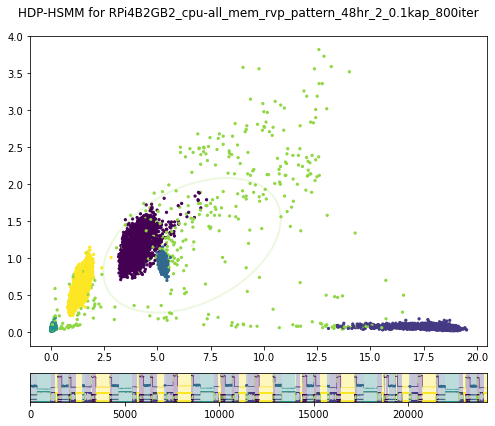

Training for 2 extra states, kappa = 0.1, and iters = 800
.........................  [  25/800,   31.88sec avg, ETA 06:51:46 ]
.........................  [  50/800,   31.67sec avg, ETA 06:35:51 ]
.........................  [  75/800,   31.68sec avg, ETA 06:22:48 ]
.........................  [ 100/800,   31.73sec avg, ETA 06:10:10 ]
.........................  [ 125/800,   31.72sec avg, ETA 05:56:53 ]
...................

KeyboardInterrupt: 

In [7]:
"""Generates HSMM Model using Grid Search"""
model, state_sequences, true_labels, states = SM.grid_search([2], [0.1,0.1,0.1,0.1,0.1], [800], "don't save fig")

In [9]:
"""Reads previously generated model and extracts it"""
model_path = 'HSMM_Models/{}_{}_{}_{}kap_{}iter.pickle'.format(device_name, feature_names, model_name,0.1,800)

model, state_sequences, true_labels = SM.get_HSMM_state_seq(labeled_data_train, model_path, device_name)

In [10]:
labeled_data_train['predicted'] = state_sequences[0]

In [11]:
"""Training"""
Labels = {}
Accuracies = []

for name,group in labeled_data_train.groupby('state'):
    print(name)
    label = labeled_data_train.groupby('state').get_group(name)['predicted'].value_counts(normalize=True)
    print(label)
    Labels[name] = label.idxmax()
    Accuracies.append(label.max())

augmented_reality
0    0.986789
6    0.013008
3    0.000203
Name: predicted, dtype: float64
game
3    0.990025
6    0.009975
Name: predicted, dtype: float64
idle
5    0.99073
6    0.00927
Name: predicted, dtype: float64
mining
1    0.974134
6    0.025866
Name: predicted, dtype: float64
stream
4    0.941385
6    0.058363
1    0.000253
Name: predicted, dtype: float64


In [12]:
labeled_data_train['label'] = labeled_data_train['state'].map(Labels)
labeled_data_test['label'] = labeled_data_test['state'].map(Labels)
#create rolling window for prediction evaluations
for pw in prediction_windows: 
    labeled_data_test[f'label - {pw} step'] = [list(map(int,window.to_list())) for window in labeled_data_test['label'].rolling(window=pw)]
    labeled_data_test[f'label - {pw} step'] = labeled_data_test[f'label - {pw} step'].shift(1-pw)

In [13]:
test_name = data_name
labeled_data_train.to_csv(f"data/{device_name}_{freq}MHz_res_usage_data_train_pred_{test_name}.csv")

In [14]:
"""Prepares test data, predictions start after lookback period"""
prediction_start = lookback
test_labels = labeled_data_test['state'].values
df = labeled_data_test[features]

In [15]:
"""Generates Label Predictions"""
prediction_windows = [1,2,5,10,15,30,60]

for prediction_window in prediction_windows:

    predicted_observations_list, observations_list = [], []
    predicted_stateseq_list = []
    test_labels_window_list = []
    log_likelihoods_list = []

    print(f"{prediction_window}-step prediction")

    for i in tqdm(range(prediction_start,len(labeled_data_test)+1)):
        
        seed_start_idx =  i - lookback
        seed_end_idx = seed_start_idx + lookback
        
        if seed_end_idx > len(labeled_data_test)-prediction_window:
            break
        
        predicted_observations, predicted_stateseq, log_likelihood = SM.HSMM_pred(model,seed_start_idx, seed_end_idx, prediction_window)
        
        predicted_observations_list.append(predicted_observations[lookback:].tolist())
        predicted_stateseq_list.append(predicted_stateseq[lookback:].tolist())
        log_likelihoods_list.append(round(log_likelihood,2))
        observations_list.append(df[i:i+prediction_window].values)

        test_labels_window_list.append(test_labels[i:i+prediction_window])  

    # store results
    predicted_stateseq_list = ['lookback']*lookback + predicted_stateseq_list
    log_likelihoods_list = ['lookback']*lookback + log_likelihoods_list


    if len(labeled_data_test) != len(predicted_stateseq_list):
        
        if prediction_window != 1:
            labeled_data_test = labeled_data_test[:-(prediction_window-1)]

    labeled_data_test[f'predicted states - {prediction_window} step'] = predicted_stateseq_list
    labeled_data_test[f'log_likelihood - {prediction_window} step'] = log_likelihoods_list

print("Done!")

1-step prediction


100%|█████████▉| 10067/10068 [07:28<00:00, 22.42it/s]


2-step prediction


100%|█████████▉| 10066/10068 [08:03<00:00, 20.82it/s]


5-step prediction


100%|█████████▉| 10062/10067 [06:49<00:00, 24.59it/s]


10-step prediction


100%|█████████▉| 10053/10063 [06:58<00:00, 24.02it/s]


15-step prediction


100%|█████████▉| 10039/10054 [07:11<00:00, 23.25it/s]


30-step prediction


100%|█████████▉| 10010/10040 [07:33<00:01, 22.07it/s]


60-step prediction


 99%|█████████▉| 9951/10011 [08:28<00:03, 19.56it/s]

Done!


In [16]:
"""Testing"""
for name,group in labeled_data_test.groupby('state'):
    print(name)
    print(labeled_data_test[lookback:].groupby('state').get_group(name)[f'predicted states - {1} step'].value_counts(normalize=True))

augmented_reality
[0]    0.944643
[6]    0.044643
[4]    0.005357
[3]    0.004167
[5]    0.000595
[1]    0.000595
Name: predicted states - 1 step, dtype: float64
game
[3]    0.916346
[6]    0.078846
[1]    0.002244
[4]    0.001603
[0]    0.000641
[5]    0.000321
Name: predicted states - 1 step, dtype: float64
idle
[5]    0.913134
[6]    0.076442
[4]    0.004170
[3]    0.003475
[0]    0.002780
Name: predicted states - 1 step, dtype: float64
mining
[1]    0.948667
[6]    0.032083
[5]    0.007404
[4]    0.006417
[0]    0.002962
[3]    0.002468
Name: predicted states - 1 step, dtype: float64
stream
[4]    0.864769
[6]    0.101423
[3]    0.016607
[0]    0.007117
[1]    0.005338
[5]    0.004745
Name: predicted states - 1 step, dtype: float64


In [17]:
"""Save test predictons"""
test_name = data_name
labeled_data_test.to_csv(f"data/{device_name}_{freq}MHz_res_usage_data_test_pred_{test_name}.csv")

In [18]:
"""remove lookback section"""
labeled_data_test = labeled_data_test[lookback:]

1 step prediction accuracy: 91.85%
1 step confusion matrix: 
mining
Recall 99.79
Specificity 94.87
Precision 98.7
F1 0.99
stream
Recall 99.6
Specificity 86.48
Precision 97.3
F1 0.98
game
Recall 99.34
Specificity 91.63
Precision 96.3
F1 0.98
augmented_reality
Recall 99.71
Specificity 94.46
Precision 98.88
F1 0.99
idle
Recall 99.71
Specificity 91.31
Precision 98.55
F1 0.99


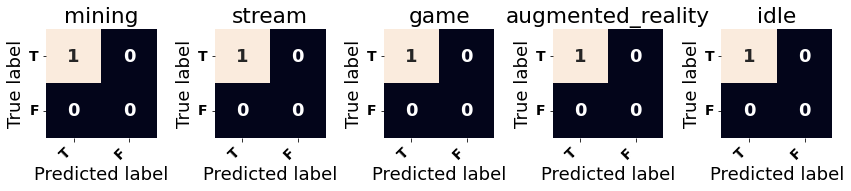

Steps 1 - MA Window 100
{'game': 'salmon', 'augmented_reality': 'lightblue', 'idle': 'lightgreen', 'mining': 'peachpuff', 'stream': 'whitesmoke'}


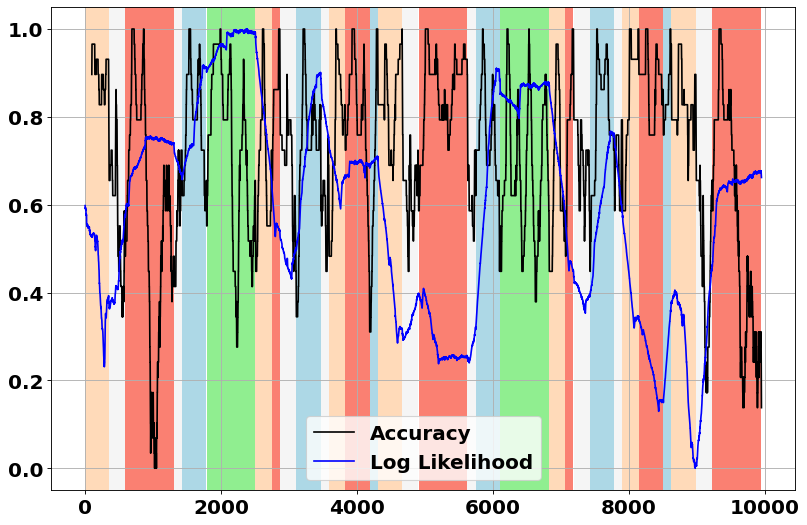

2 step prediction accuracy: 89.62%
2 step confusion matrix: 
mining
Recall 99.54
Specificity 93.51
Precision 98.36
F1 0.99
stream
Recall 99.31
Specificity 84.82
Precision 96.98
F1 0.98
game
Recall 99.16
Specificity 89.09
Precision 95.21
F1 0.97
augmented_reality
Recall 99.46
Specificity 91.28
Precision 98.25
F1 0.99
idle
Recall 99.61
Specificity 88.99
Precision 98.16
F1 0.99


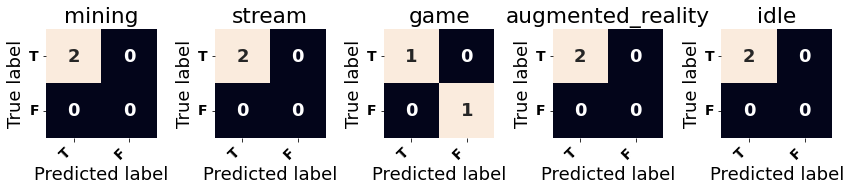

Steps 2 - MA Window 100
{'game': 'salmon', 'augmented_reality': 'lightblue', 'idle': 'lightgreen', 'mining': 'peachpuff', 'stream': 'whitesmoke'}


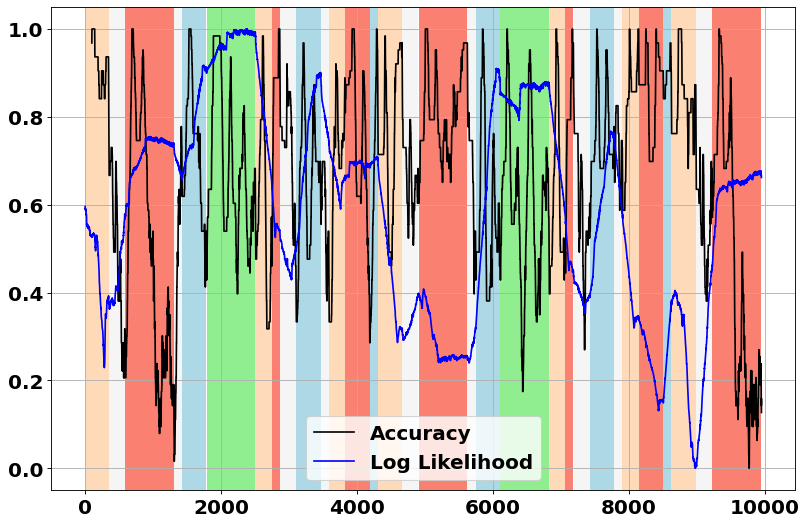

5 step prediction accuracy: 84.79%
5 step confusion matrix: 
mining
Recall 98.16
Specificity 91.36
Precision 97.8
F1 0.98
stream
Recall 97.74
Specificity 78.09
Precision 95.62
F1 0.97
game
Recall 97.75
Specificity 83.44
Precision 92.82
F1 0.95
augmented_reality
Recall 98.34
Specificity 87.57
Precision 97.5
F1 0.98
idle
Recall 99.02
Specificity 83.07
Precision 97.19
F1 0.98


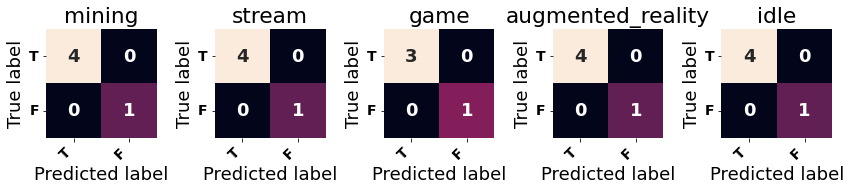

Steps 5 - MA Window 100
{'game': 'salmon', 'augmented_reality': 'lightblue', 'idle': 'lightgreen', 'mining': 'peachpuff', 'stream': 'whitesmoke'}


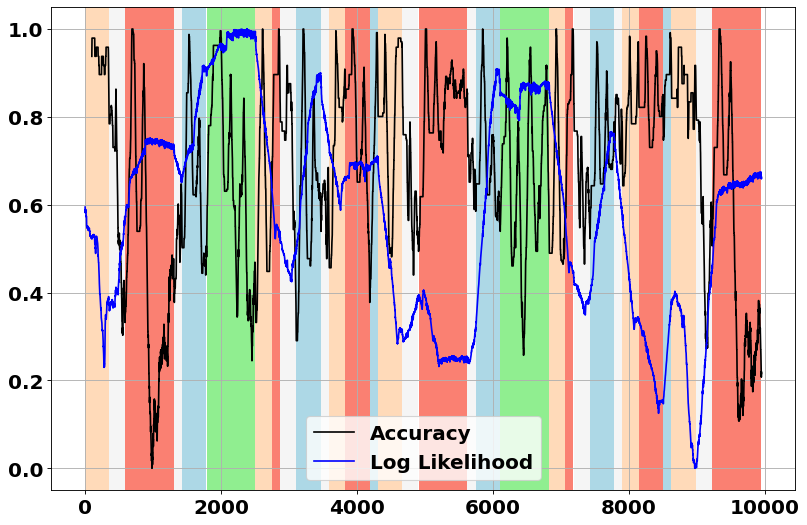

10 step prediction accuracy: 79.75%
10 step confusion matrix: 
mining
Recall 96.52
Specificity 88.38
Precision 97.02
F1 0.97
stream
Recall 95.32
Specificity 73.61
Precision 94.64
F1 0.95
game
Recall 95.79
Specificity 77.53
Precision 90.32
F1 0.93
augmented_reality
Recall 96.93
Specificity 82.15
Precision 96.4
F1 0.97
idle
Recall 97.76
Specificity 76.89
Precision 96.16
F1 0.97


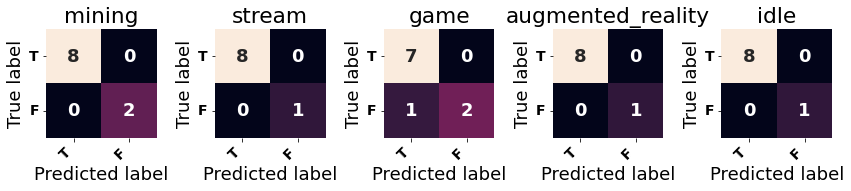

Steps 10 - MA Window 100
{'game': 'salmon', 'augmented_reality': 'lightblue', 'idle': 'lightgreen', 'mining': 'peachpuff', 'stream': 'whitesmoke'}


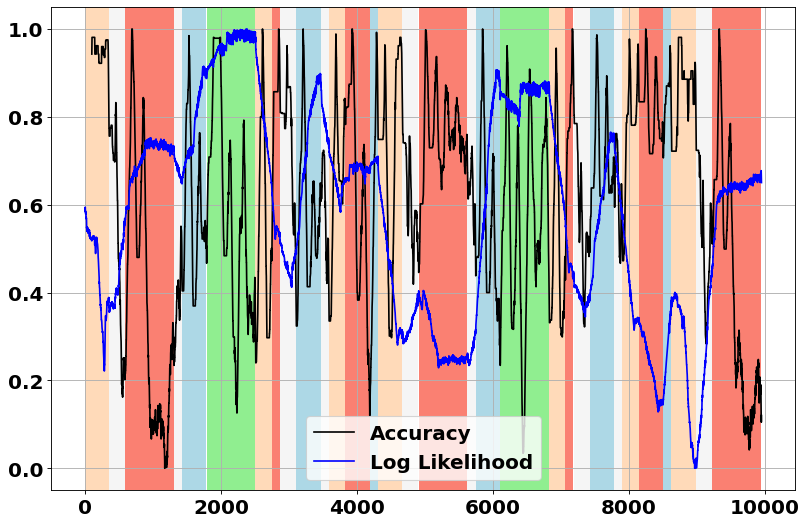

15 step prediction accuracy: 75.79%
15 step confusion matrix: 
mining
Recall 94.69
Specificity 86.91
Precision 96.6
F1 0.96
stream
Recall 94.07
Specificity 65.63
Precision 93.03
F1 0.94
game
Recall 94.28
Specificity 74.28
Precision 88.92
F1 0.92
augmented_reality
Recall 95.77
Specificity 77.27
Precision 95.4
F1 0.96
idle
Recall 97.02
Specificity 73.67
Precision 95.61
F1 0.96


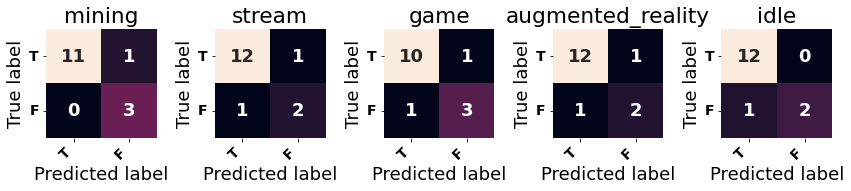

Steps 15 - MA Window 100
{'game': 'salmon', 'augmented_reality': 'lightblue', 'idle': 'lightgreen', 'mining': 'peachpuff', 'stream': 'whitesmoke'}


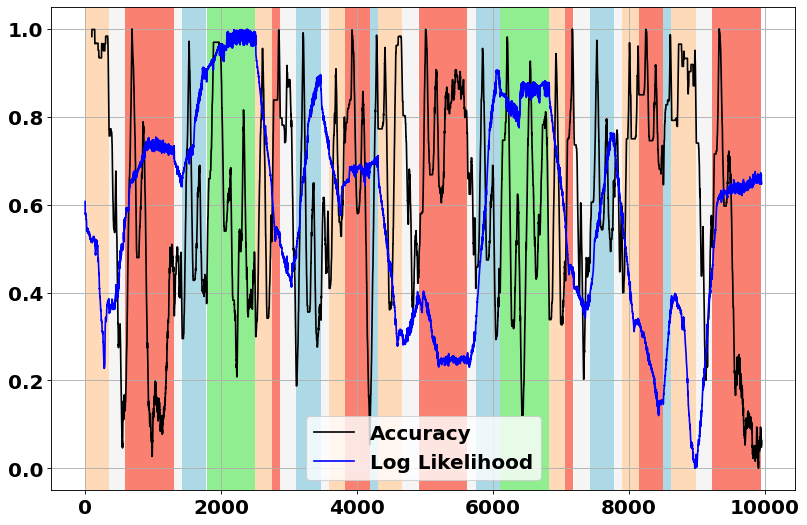

30 step prediction accuracy: 68.64%
30 step confusion matrix: 
mining
Recall 92.3
Specificity 81.61
Precision 95.2
F1 0.94
stream
Recall 90.69
Specificity 58.62
Precision 91.4
F1 0.91
game
Recall 91.52
Specificity 66.73
Precision 85.76
F1 0.89
augmented_reality
Recall 94.12
Specificity 68.65
Precision 93.66
F1 0.94
idle
Recall 96.07
Specificity 66.48
Precision 94.43
F1 0.95


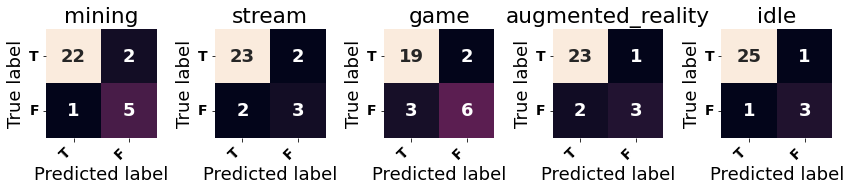

Steps 30 - MA Window 100
{'game': 'salmon', 'augmented_reality': 'lightblue', 'idle': 'lightgreen', 'mining': 'peachpuff', 'stream': 'whitesmoke'}


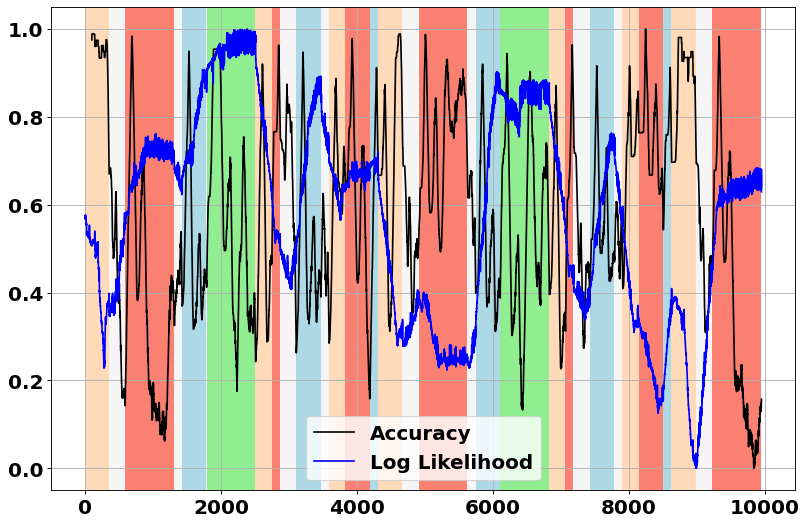

60 step prediction accuracy: 58.37%
60 step confusion matrix: 
mining
Recall 88.87
Specificity 72.11
Precision 92.7
F1 0.91
stream
Recall 88.23
Specificity 43.74
Precision 88.27
F1 0.88
game
Recall 88.0
Specificity 59.69
Precision 82.7
F1 0.85
augmented_reality
Recall 91.86
Specificity 58.01
Precision 91.5
F1 0.92
idle
Recall 93.81
Specificity 54.27
Precision 92.39
F1 0.93


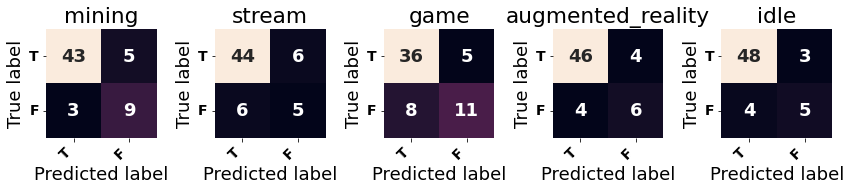

Steps 60 - MA Window 100
{'game': 'salmon', 'augmented_reality': 'lightblue', 'idle': 'lightgreen', 'mining': 'peachpuff', 'stream': 'whitesmoke'}


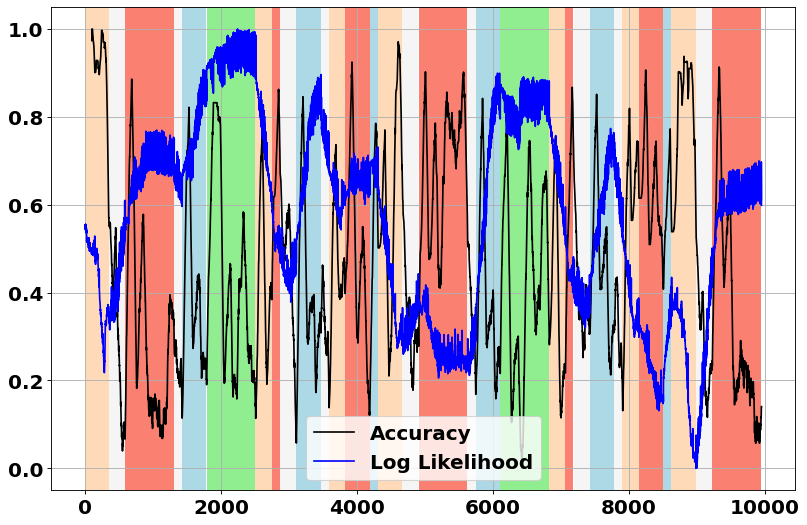

In [19]:
"""Analysis of Predictions"""

plt.rc('font', **{'weight' : 'bold', 'size'   : 18})

for prediction_window in prediction_windows:
    accuracy, conf_matrix = [], []
    for index, row in labeled_data_test.iterrows():
        accuracy.append(accuracy_score(row[f'label - {prediction_window} step'], row[f'predicted states - {prediction_window} step'])*100)
        conf_matrix.append(multilabel_confusion_matrix(row[f'label - {prediction_window} step'], row[f'predicted states - {prediction_window} step'], labels=labeled_data_test['label'].unique().tolist()))

    labeled_data_test[f'accuracy - {prediction_window} step'] = accuracy
    labeled_data_test[f'confusion matrix - {prediction_window} step'] = conf_matrix
   

    print(f"{prediction_window} step prediction accuracy: {round(mean(accuracy),2)}%")
    print(f"{prediction_window} step confusion matrix: ")

    SM.classification_report(conf_matrix, labeled_data_test['state'].unique().tolist())

    SM.plot_accuracy_likelihood(prediction_window, 100)